In [1]:
%matplotlib inline

from pathlib import Path
import json
import sys
sys.path.append("../../")

import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile

data_dir = Path('/home/hadim/Drive/Data/Fake Microtubules/anamic')

../../anamic/transformations.py:1916: UserWarning: No module named 'anamic._transformations'
  warnings.warn(str(err))


In [37]:
# Useful functions
import numpy as np
from scipy import ndimage


def get_point_from_vector(vec, point, distance):
    """Given a vector get the coordinate of the point
    at a certain distance from the input point.
    
    Args:
        vec: array, vector.
        point: array, input point.
        distance: float, the distance.
    """
    norm = np.sqrt(np.sum(vec ** 2))
    return point + (vec / norm) * distance


def discretize_line(line, spacing):
    """Return a list points located at equidistance on the input line.
    
    The list will also include the input line points.
    
    Args:
        line: array, shape=2x2
        spacing: float, the distance between each points.
    
    """
    
    vec = line[1] - line[0]
    norm = np.sqrt(np.sum(vec ** 2))

    points = [line[0]]

    distances = np.arange(0, np.round(norm), spacing)
    for d in distances:
        p = get_point_from_vector(vec, start_point, d)
        points.append(p)

    points.append(line[1])
    points = np.array(points)
    return points

In [2]:
condition = "taper_length_nm_0000"
fnames = list((data_dir / condition).glob("*.tif"))

index = 0
fname = fnames[index]

# Open the image
im = tifffile.imread(str(fname))

# Load metadata
metadata = json.load(open(fname.with_suffix('.json')))

# Get line coordinates
p1 = np.array(metadata['tip_start'])
p2 = np.array(metadata['tip_end'])
line = np.array([p1, p2])

In [7]:
# We define a new line we are going to use for the fitting process

pixel_size = metadata['pixel_size']
offset_start = 3000  # nm
offset_end = 2000  # nm
offset_start_pixel = offset_start / pixel_size
offset_end_pixel = offset_end / pixel_size

# Calculate the vector of the line and its norm
vec = p2 - p1

# Get the coordinates of the points we'll use
# to for line fitting.
start_point = get_point_from_vector(-vec, p2, offset_start_pixel)
end_point = get_point_from_vector(vec, p2, offset_end_pixel)
line_fit_tips = np.array([start_point, end_point])

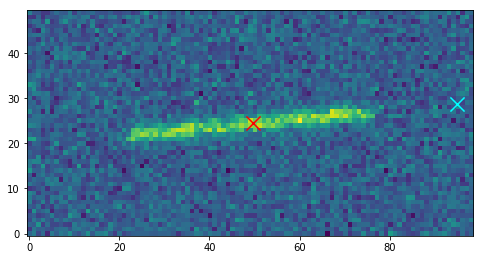

In [15]:
# Check the calculated end and start points.
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(im, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

(x1, y1), (x2, y2) = line_fit_tips
ax.scatter(y1, x1, color='red', s=200, marker="x")
ax.scatter(y2, x2, color='cyan', s=200, marker="x")

In [53]:
# Now we compute all the points contained
# in the line separated by a defined distance (`spacing`).

# We like to use a spacing < 1 pixel to get 
# subpixel resolution accuracy during fitting.

spacing = 0.1  # pixel
points = discretize_line(line_fit_tips, spacing)

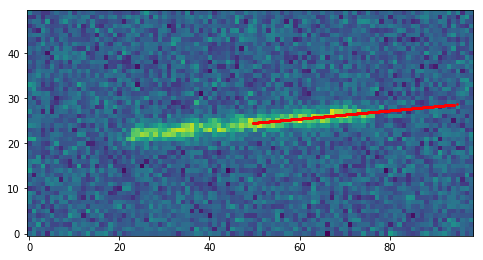

In [54]:
# Check the points
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(im, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

ax.scatter(points[:, 1], points[:, 0], color='red', s=10, marker=".")

Text(0, 0.5, 'Intensities')

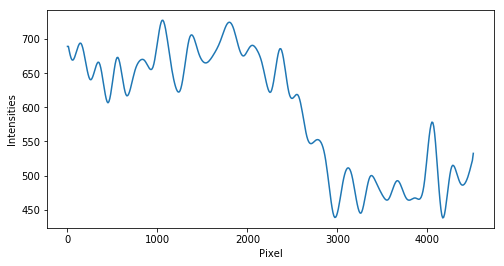

In [60]:
# Get the intensity profile of the line.
y_profile = ndimage.map_coordinates(im, points.T, order=3, mode='constant')

# Define the x values of the profile so the unit is a pixel.
x_profile = np.arange(0, points.shape[0]) / spacing

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(x_profile, y_profile)
ax.set_xlabel("Pixel")
ax.set_ylabel("Intensities")
#ax.set_ylim(0, 800)